In [3]:
import numpy as np
from pandas_datareader import data 
apple = data.DataReader('AFI.AX', 'yahoo', start='1/1/2010', end= '1/10/2015')
apple['Returns'] = apple['Adj Close'].pct_change()
mu = apple['Returns'].mean()
std = apple['Returns'].std()

def sample_data(n_samples=50000, seq_length=10):

    vectors = []

    for i in range(n_samples):
        daily_returns=np.random.normal(mu, std, seq_length)
        vectors.append(daily_returns)
    
    return np.asarray(vectors)

In [5]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Conv1D, Reshape, LSTM
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# MNIST dataset

x_train = sample_data(seq_length=20)
#x_train = x_train.reshape(50000, 20, 1)
original_dim = x_train.shape[1]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 32
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
inputs2 = Reshape((original_dim, 1))(inputs)
x = LSTM(intermediate_dim)(inputs2)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# #print(x.shape, y.shape)


# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

W0831 13:57:17.688467 4628506048 deprecation_wrapper.py:119] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4409: The name tf.random_normal is deprecated. Please use tf.random.normal instead.



(?, 32)
Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 20, 1)        0           encoder_input[0][0]              
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 32)           4352        reshape_2[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            66          lstm_3[0][0]                     
____________________________________________________________________________________

In [6]:
models = (encoder, decoder)
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

W0831 13:57:22.228561 4628506048 deprecation_wrapper.py:119] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 20)                0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 4484      
_________________________________________________________________
decoder (Model)              (None, 20)                756       
Total params: 5,240
Trainable params: 5,240
Non-trainable params: 0
_________________________________________________________________


In [7]:
x_test = sample_data(10000, seq_length=20)
#x_test = x_test.reshape(10000, 20, 1)

In [8]:
x_test.shape, x_train.shape

((10000, 20), (50000, 20))

In [9]:
vae.fit(x_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(x_test, None))

W0831 13:57:27.805227 4628506048 deprecation.py:323] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0831 13:57:29.061381 4628506048 deprecation_wrapper.py:119] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 240us/step - loss: 1.3585 - val_loss: 0.2290
Epoch 2/50
50000/50000 [==============================] - 10s 209us/step - loss: 0.1860 - val_loss: 0.1690
Epoch 3/50
50000/50000 [==============================] - 10s 210us/step - loss: 0.1641 - val_loss: 0.1614
Epoch 4/50
50000/50000 [==============================] - 10s 208us/step - loss: 0.1601 - val_loss: 0.1593
Epoch 5/50
50000/50000 [==============================] - 10s 207us/step - loss: 0.1587 - val_loss: 0.1584
Epoch 6/50
50000/50000 [==============================] - 12s 238us/step - loss: 0.1581 - val_loss: 0.1581
Epoch 7/50
50000/50000 [==============================] - 11s 215us/step - loss: 0.1578 - val_loss: 0.1578
Epoch 8/50
50000/50000 [==============================] - 13s 260us/step - loss: 0.1576 - val_loss: 0.1577
Epoch 9/50
50000/50000 [==============================] - 11s 220us/step - loss: 0.1575 - val_

In [10]:
from tqdm import tqdm

In [11]:
grid_x = np.linspace(-2, 2, 100)
grid_y = np.linspace(-2, 2, 100)[::-1]

gen_data = []
for i, yi in tqdm(enumerate(grid_y)):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        gen_data.append(x_decoded[0])
        #print(z_sample.shape)

gen_data = np.array(gen_data)

100it [00:04, 21.81it/s]


In [12]:
ids = np.random.choice(10000, 100)

In [13]:
def series_from_returns(start, returns):
    res = [start]
    for ret in returns:
        res.append(res[-1]*ret + res[-1])
    return res

In [14]:
start = apple['Adj Close'][0]

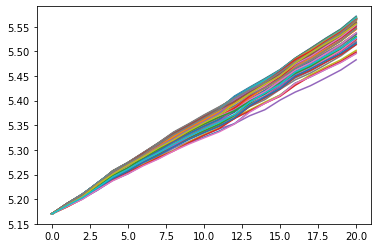

In [15]:
start = apple['Adj Close'][0]
for sample in gen_data[ids]:
    plt.plot(series_from_returns(start, sample))

In [16]:
np.mean(gen_data), np.std(gen_data)

(0.0035726056, 0.000559398)

In [17]:
np.mean(samples), np.std(samples)

(0.0037963417386169137, 0.08856171691949072)

In [18]:
from scipy import stats
p_value = np.mean([stats.normaltest(gen_data[i]).pvalue for i in ids])
print("Mean p_value", p_value)

Mean p_value 0.33963717692282286


In [19]:
mu = apple['Adj Close'].mean()
std = apple['Adj Close'].std()

# More Layers

In [4]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Lambda, Input, Dense, Conv1D, Reshape, LSTM
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


# MNIST dataset

x_train = sample_data(seq_length=20)
#x_train = x_train.reshape(50000, 20, 1)
original_dim = x_train.shape[1]

# network parameters
input_shape = (original_dim, )
intermediate_dim = 32
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
inputs2 = Reshape((original_dim, 1))(inputs)
x = LSTM(intermediate_dim)(inputs2)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)
# #print(x.shape, y.shape)


# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim, ), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
#plot_model(encoder, to_file='vae_mlp_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Reshape((latent_dim, 1))(latent_inputs)
x = Dense(intermediate_dim, activation='relu')(x)
x = LSTM(intermediate_dim)(x)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
#plot_model(decoder, to_file='vae_mlp_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

W0901 09:17:28.354603 4521981376 deprecation_wrapper.py:119] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:541: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0901 09:17:28.374628 4521981376 deprecation_wrapper.py:119] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:66: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0901 09:17:28.394067 4521981376 deprecation_wrapper.py:119] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4432: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0901 09:17:28.693112 4521981376 deprecation_wrapper.py:119] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4409: The name tf.random_normal is deprecated. Please use tf.random.no

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 20, 1)        0           encoder_input[0][0]              
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 32)           4352        reshape_1[0][0]                  
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            66          lstm_1[0][0]                     
____________________________________________________________________________________________

In [5]:
models = (encoder, decoder)
reconstruction_loss = mse(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')
vae.summary()

W0901 09:17:31.178355 4521981376 deprecation_wrapper.py:119] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/keras/optimizers.py:793: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



Model: "vae_mlp"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 20)                0         
_________________________________________________________________
encoder (Model)              [(None, 2), (None, 2), (N 4484      
_________________________________________________________________
decoder (Model)              (None, 20)                9044      
Total params: 13,528
Trainable params: 13,528
Non-trainable params: 0
_________________________________________________________________


In [7]:
x_test = sample_data(10000, seq_length=20)
vae.fit(x_train,
        epochs=20,
        batch_size=batch_size,
        validation_data=(x_test, None))

W0901 09:17:53.212276 4521981376 deprecation.py:323] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0901 09:17:55.911144 4521981376 deprecation_wrapper.py:119] From /Users/ekaterinapogodina/venv3.7/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:1033: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 50000 samples, validate on 10000 samples
Epoch 1/20
50000/50000 [==============================] - 15s 306us/step - loss: 0.8286 - val_loss: 0.1600
Epoch 2/20
50000/50000 [==============================] - 11s 224us/step - loss: 0.1588 - val_loss: 0.1580
Epoch 3/20
50000/50000 [==============================] - 13s 258us/step - loss: 0.1578 - val_loss: 0.1576
Epoch 4/20
50000/50000 [==============================] - 10s 200us/step - loss: 0.1575 - val_loss: 0.1575
Epoch 5/20
50000/50000 [==============================] - 10s 198us/step - loss: 0.1574 - val_loss: 0.1574
Epoch 6/20
50000/50000 [==============================] - 10s 201us/step - loss: 0.1574 - val_loss: 0.1574
Epoch 7/20
50000/50000 [==============================] - 10s 202us/step - loss: 0.1573 - val_loss: 0.1574
Epoch 8/20
50000/50000 [==============================] - 10s 202us/step - loss: 0.1573 - val_loss: 0.1573
Epoch 9/20
50000/50000 [==============================] - 10s 204us/step - loss: 0.1573 - val_

In [8]:
from tqdm import tqdm

grid_x = np.linspace(-2, 2, 100)
grid_y = np.linspace(-2, 2, 100)[::-1]

gen_data = []
for i, yi in tqdm(enumerate(grid_y)):
    for j, xi in enumerate(grid_x):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        gen_data.append(x_decoded[0])
        #print(z_sample.shape)

gen_data = np.array(gen_data)

100it [00:09, 10.38it/s]


In [9]:
ids = np.random.choice(10000, 100)
def series_from_returns(start, returns):
    res = [start]
    for ret in returns:
        res.append(res[-1]*ret + res[-1])
    return res

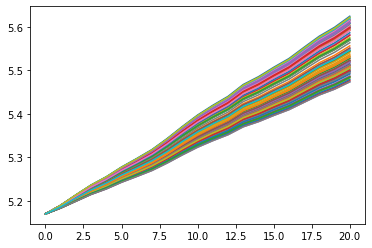

In [10]:
start = apple['Adj Close'][0]
for sample in gen_data[ids]:
    plt.plot(series_from_returns(start, sample))

In [11]:
np.mean(gen_data), np.std(gen_data)

(0.0034952224, 0.0006148129)

In [12]:
from scipy import stats
p_value = np.mean([stats.normaltest(gen_data[i]).pvalue for i in ids])
print("Mean p_value", p_value)

Mean p_value 0.3894552177653852
